In [1]:
from time import time, process_time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from utility import *
from LSTM import *

homedir = get_homedir()

In [2]:
# FIPS_mapping, FIPS_full = get_FIPS(reduced=True)

In [2]:
FIPS_cluster = []
for c in range(5):
    with open(f'{homedir}/JK/preprocessing/0511/FIPS_cluster_cls={c}.txt', 'r') as f:
        FIPS_cluster.append(eval(f.read()))
FIPS_cluster[0][:5]

['06049', '08009', '08017', '08061', '08073']

In [3]:
print(len(FIPS_cluster[0]),len(FIPS_cluster[1]),len(FIPS_cluster[2]),len(FIPS_cluster[3]),len(FIPS_cluster[4]))

196 1004 1784 100 30


In [3]:
dataList = [np.load(f'{homedir}/JK/preprocessing/0511/dataList_cls={c}.npy', allow_pickle=True) for c in range(5)]
dataList[1].shape

(1004, 69, 46)

In [4]:
with open(f'{homedir}/JK/preprocessing/0511/columns.txt', 'r') as f:
    columns = eval(f.read())

In [5]:
target_idx = columns.index('deaths')
split_ratio = 0.1
QUANTILE = list(quantileList)
history_size = 7
target_size = 14
step_size = 1
NUM_CELLS = 128
lr = 0.001
dp = 0.2
EPOCHS = 3

Quantile=10 is trained
Train for 200 steps, validate for 50 steps
Epoch 1/3
200/200 [==============================] - 3s 14ms/step - loss: 0.0327 - val_loss: 0.0584
Epoch 2/3
200/200 [==============================] - 1s 5ms/step - loss: 0.0208 - val_loss: 0.0537
Epoch 3/3
200/200 [==============================] - 1s 5ms/step - loss: 0.0183 - val_loss: 0.0508
Quantile=20 is trained
Train for 200 steps, validate for 50 steps
Epoch 1/3
200/200 [==============================] - 3s 13ms/step - loss: 0.0446 - val_loss: 0.0999
Epoch 2/3
200/200 [==============================] - 1s 5ms/step - loss: 0.0313 - val_loss: 0.0896
Epoch 3/3
200/200 [==============================] - 1s 5ms/step - loss: 0.0264 - val_loss: 0.0803
Quantile=30 is trained
Train for 200 steps, validate for 50 steps
Epoch 1/3
200/200 [==============================] - 3s 13ms/step - loss: 0.0556 - val_loss: 0.1452
Epoch 2/3
200/200 [==============================] - 1s 5ms/step - loss: 0.0462 - val_loss: 0.1184
Epoch 3

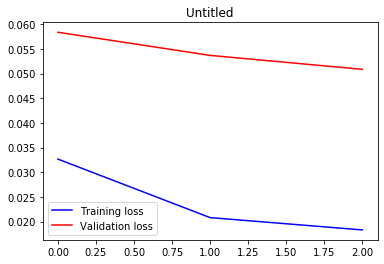

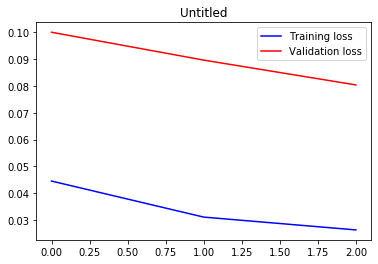

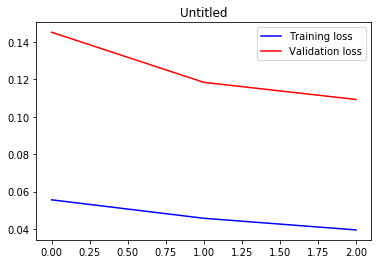

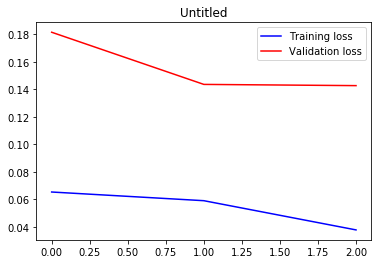

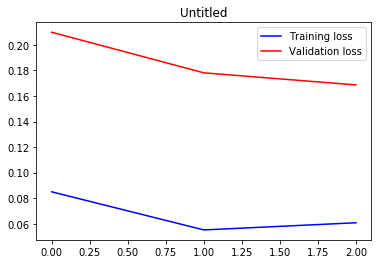

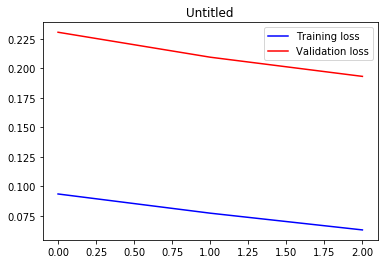

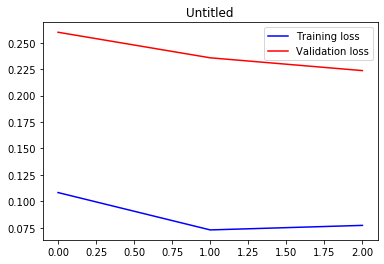

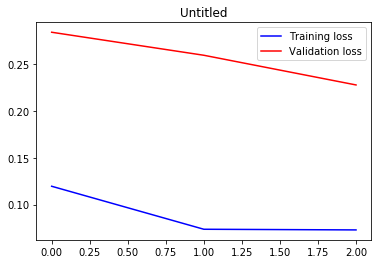

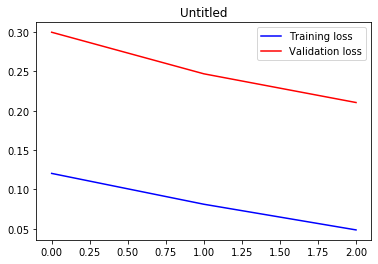

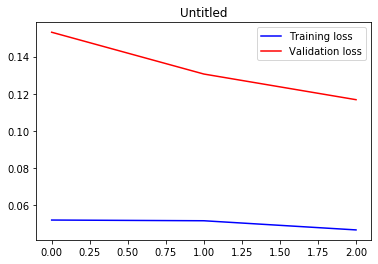

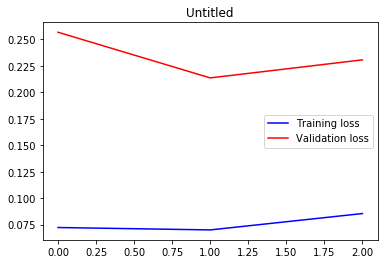

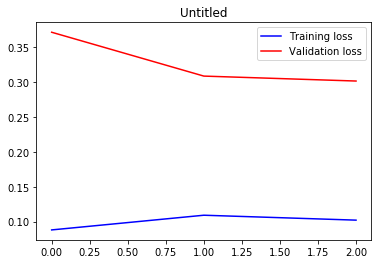

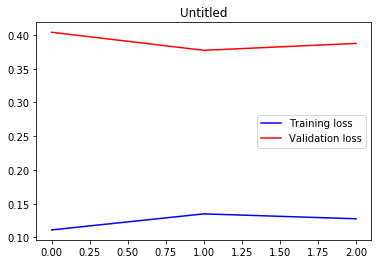

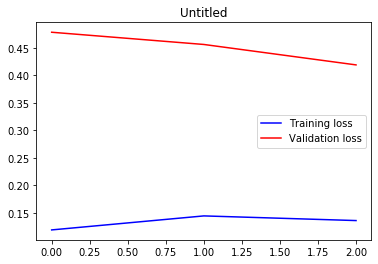

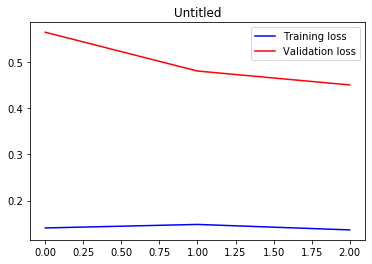

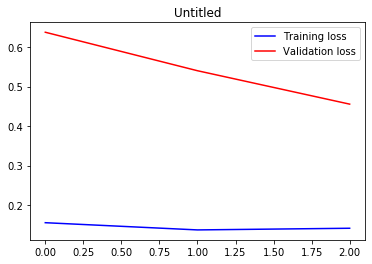

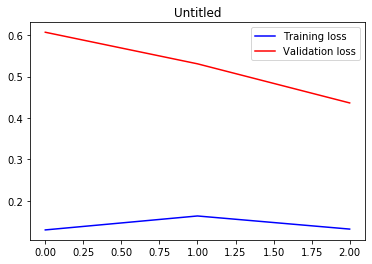

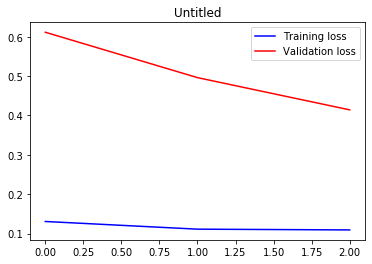

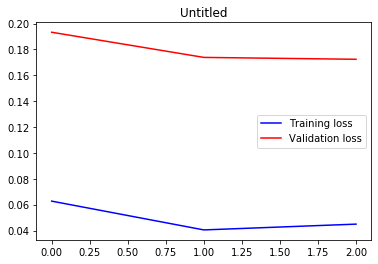

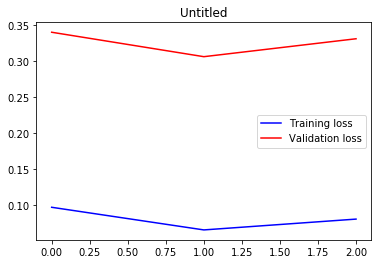

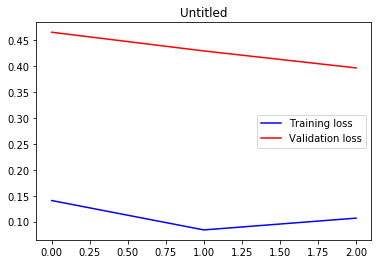

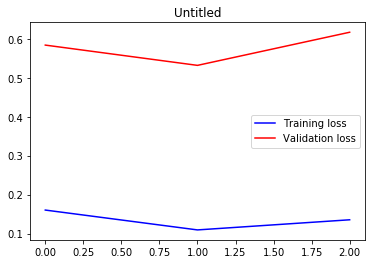

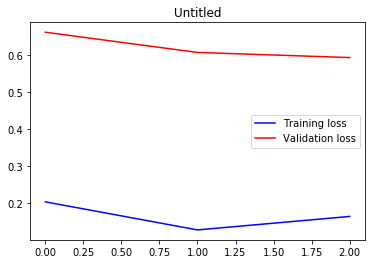

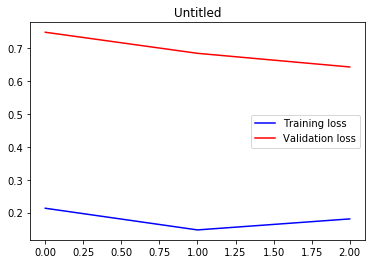

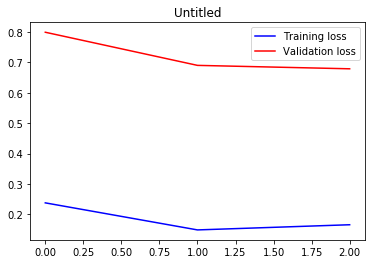

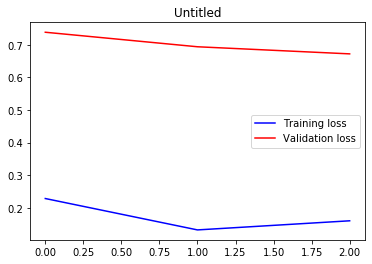

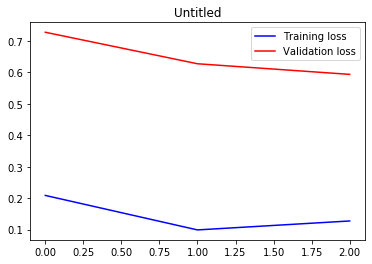

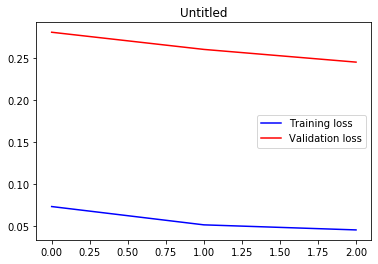

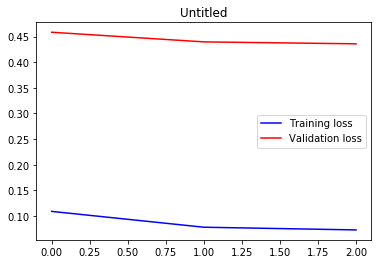

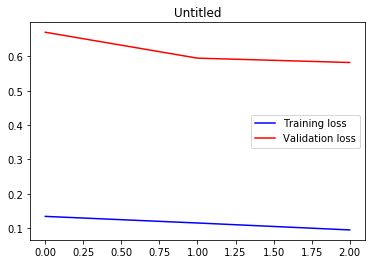

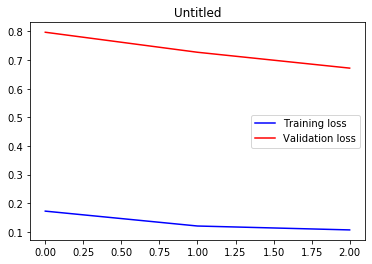

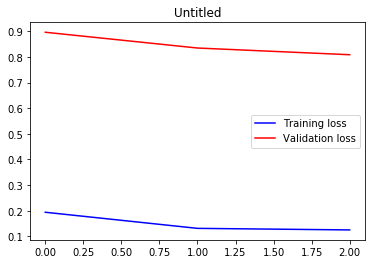

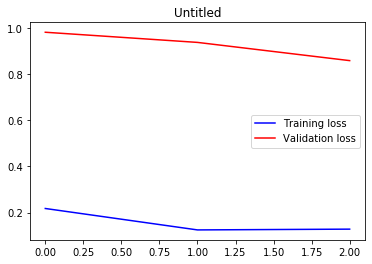

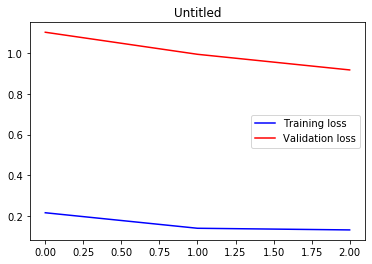

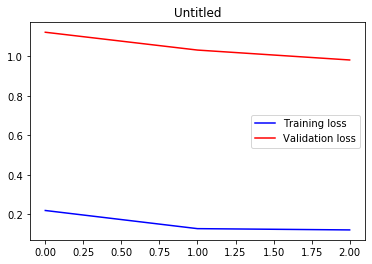

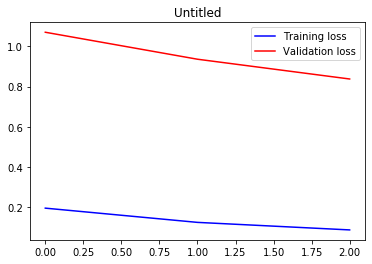

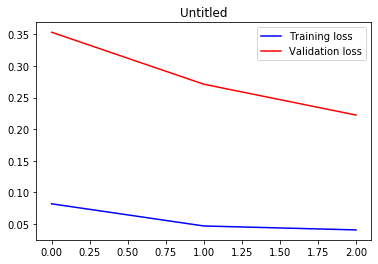

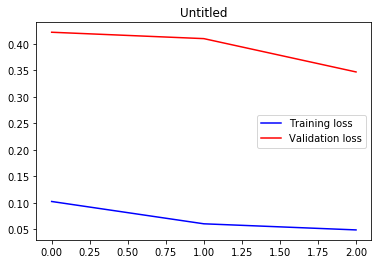

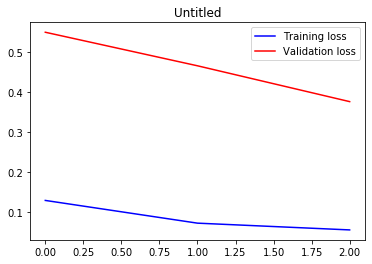

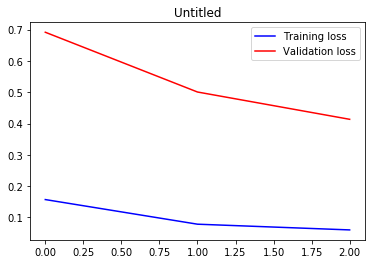

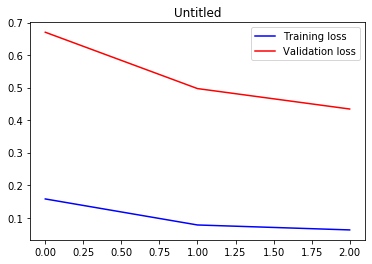

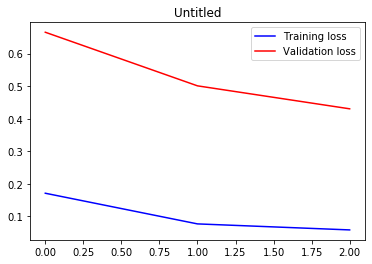

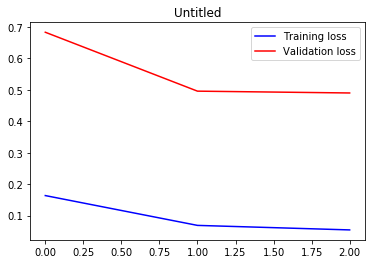

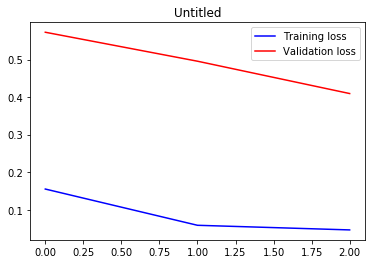

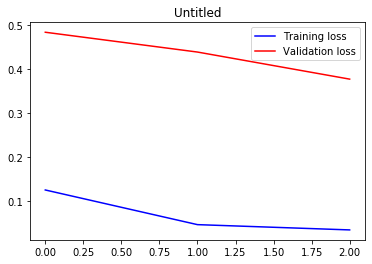

In [6]:
import os

PATH = f"{homedir}/JK/prediction/0511"
try:
    os.mkdir(PATH)
except OSError as error:
    print(error)

for c in range(5):
    X_train, y_train, X_val, y_val = train_val_split(dataList[c], target_idx, history_size, target_size, split_ratio=split_ratio, step_size=step_size)

    scaler, *_ = get_StandardScaler(X_train)
    X_train, y_train = normalizer(scaler, X_train, y_train, target_idx)
    X_val, y_val = normalizer(scaler, X_val, y_val, target_idx)

    train_data, val_data = load_Dataset(X_train, y_train, X_val, y_val)

    history_size = train_data.element_spec[0].shape[1]
    feature_size = train_data.element_spec[0].shape[2]
    target_size = train_data.element_spec[1].shape[1]

    model_qntl, history_qntl = LSTM_fit(train_data, val_data, lr=lr, NUM_CELLS=NUM_CELLS, EPOCHS=EPOCHS, dp=dp, monitor=True)

    for i in range(len(QUANTILE)):
        FILEPATH = f"/LSTM_class={c}_qntl={10*(i+1)}"
        plot_train_history(history_qntl[i], title='Untitled', path=PATH+FILEPATH+'.png')
        # np.save(PATH+FILEPATH+'.npy', np.vstack((LOSS, VAL_LOSS)).astype(np.float32))

    df_future = predict_future(model_qntl, dataList[c], scaler, target_idx, FIPS=FIPS_cluster[c], date_ed=pd.Timestamp('2020-05-08'))
    df_future.to_csv(PATH+f'/LSTM_class={c}_0511.csv', index=False)

In [19]:
for c in range(5):
    if c==0:
        forecasted = pd.read_csv(f'{homedir}/JK/prediction/0511/LSTM_class={c}_0511.csv', parse_dates=[0])
        print(len(forecasted))
    else:
        forecasted = forecasted.append(pd.read_csv(f'{homedir}/JK/prediction/0511/LSTM_class={c}_0511.csv', parse_dates=[0]))
        print(len(forecasted))
forecasted['fips'] = forecasted['fips'].apply(correct_FIPS)
forecasted.head()

2744
16800
41776
43176
43596


,date,fips,10,20,30,40,50,60,70,80,90
0,2020-05-09,06049,-0.000279,-0.000422,-0.000041,0.000170,-0.000056,0.000298,0.000145,0.000093,0.000745
1,2020-05-10,06049,-0.000504,-0.000231,0.000108,0.000024,0.000031,0.000106,0.000263,0.000028,0.000691
2,2020-05-11,06049,-0.000329,-0.000178,0.000020,-0.000148,0.000023,0.000143,0.000318,0.000172,0.000269
3,2020-05-12,06049,-0.000060,-0.000182,-0.000085,0.000423,0.000048,0.000273,0.000446,0.000105,0.000563
4,2020-05-13,06049,-0.000012,0.000116,-0.000060,-0.000043,0.000026,0.000097,0.000018,0.000194,0.000381


In [26]:
forecasted[(forecasted['date']==pd.Timestamp('2020-05-09')) & (forecasted['fips']=='10005')]

,date,fips,10,20,30,40,50,60,70,80,90
291,2020-05-09,10005,67.29306,83.079727,94.392578,81.651993,75.413254,71.862732,75.028366,113.120956,69.369766


In [20]:
forecasted = fix_FIPS(forecasted, fipslabel='fips', datelabel='date')
submission_df = to_multi_idx(forecasted, fipslabel='fips', datelabel='date')
submission_df[submission_df<0]=0.0
submission_df.head()

,10,20,30,40,50,60,70,80,90
id,,,,,,,,,
2020-05-09-1001,2.491985,3.412499,3.052619,2.911892,3.710819,3.174699,2.646794,3.127977,2.727879
2020-05-09-1003,3.450260,5.753233,4.481454,4.163937,5.645250,5.205556,6.090033,5.069814,5.748330
2020-05-09-1005,0.000000,0.000000,0.016391,0.000455,0.887446,0.000000,0.165116,0.121513,0.796695
2020-05-09-1007,0.713842,0.805795,0.745814,0.905932,1.030614,0.974301,0.239916,0.868576,0.996753
2020-05-09-1009,0.000000,0.000000,0.000000,0.000000,0.008904,0.000000,0.216896,0.026626,0.594943


In [21]:
base_pred = pd.read_csv(f'{homedir}/JK/prediction/0509/base_prediction.csv')
base_pred.set_index('id', inplace=True)
base_pred.head()

,10,20,30,40,50,60,70,80,90
id,,,,,,,,,
2020-04-01-10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01-10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01-10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01-1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
base_pred.update(submission_df)

In [24]:
base_pred.loc['2020-05-09-10005']

10     67.293060
20     83.079727
30     94.392578
40     81.651993
50     75.413254
60     71.862732
70     75.028366
80    113.120956
90     69.369766
Name: 2020-05-09-10005, dtype: float64

In [16]:
_ = base_pred.reset_index()

In [17]:
_.to_csv(f'{homedir}/submissions/LSTM_0511.csv', index=False)

In [35]:
forecasted = pd.read_csv(f'{homedir}/JK/prediction/0525/LSTM_0525.csv', parse_dates=[0])
_ = prediction_to_submission(forecasted)
_.to_csv(f'{homedir}/submissions/LSTM_0525.csv', index=False)

In [4]:
PATH_PREP = f"{homedir}/JK/preprocessing/0523"
data_ctg = np.load(PATH_PREP+f'/data_ctg.npy', allow_pickle=True)
print(f'Categorical data of shape {data_ctg.shape} is loaded.')
data_ts = np.load(PATH_PREP+f'/data_ts.npy', allow_pickle=True)
print(f'Timeseries data of shape {data_ts.shape} is loaded.')

Categorical data of shape (3114, 45) is loaded.
Timeseries data of shape (3114, 80, 8) is loaded.


In [9]:
_ = pd.read_csv(f'{homedir}/data/us/demographics/county_land_areas.csv', usecols=[0,2,3,4,5])
_['County FIPS'] = _['County FIPS'].apply(correct_FIPS)
_.head()

,County FIPS,Area in square miles - Total area,Area in square miles - Land area,2010 Density per square mile of land area - Population,2010 Density per square mile of land area - Housing units
0,01001,604.39,594.44,91.8,37.2
1,01003,2027.31,1589.78,114.6,65.5
2,01005,904.52,884.88,31.0,13.4
3,01007,626.17,622.58,36.8,14.4
4,01009,650.63,644.78,88.9,37.0


In [10]:
with open(PATH_PREP+f'/FIPS.txt', 'r') as f:
    FIPS_total = eval(f.read())
FIPS_total_set = set(FIPS_total)
land = set(_['County FIPS'])

In [3]:
forecasted0 = pd.read_csv(f'{homedir}/JK/prediction/0525/LSTM_mult_hist_size_7_0525_0.csv', parse_dates=[0])
forecasted1 = pd.read_csv(f'{homedir}/JK/prediction/0525/LSTM_mult_hist_size_7_0525_1.csv', parse_dates=[0])
forecasted2 = pd.read_csv(f'{homedir}/JK/prediction/0525/LSTM_mult_hist_size_7_0525_2.csv', parse_dates=[0])
_ = prediction_to_submission([forecasted0,forecasted1,forecasted2])
_.to_csv(f'{homedir}/submissions/LSTM_0525_hist_size_7.csv', index=False)

In [31]:
PATH_PREP = f"{homedir}/JK/preprocessing/0525"
data_ctg = np.load(PATH_PREP+f'/data_ctg.npy', allow_pickle=True)
print(f'Categorical data of shape {data_ctg.shape} is loaded.')
data_ts = np.load(PATH_PREP+f'/data_ts.npy', allow_pickle=True)
print(f'Timeseries data of shape {data_ts.shape} is loaded.')

Categorical data of shape (3114, 51) is loaded.
Timeseries data of shape (3114, 83, 8) is loaded.


In [37]:
data_ctg = np.load(f'{homedir}/JK/HC/dataList_static.npy', allow_pickle=True)
print(f'Categorical data of shape {data_ctg.shape} is loaded.')
data_ts = np.load(f'{homedir}/JK/HC/dataList_time.npy', allow_pickle=True)
print(f'Timeseries data of shape {data_ts.shape} is loaded.')

Categorical data of shape (2920, 1) is loaded.
Timeseries data of shape (2920, 85, 10) is loaded.


In [39]:
with open(f'{homedir}/JK/HC/fipsList for dataList.txt', 'r') as f:
    FIPS_total = eval(f.read())

In [41]:
len(FIPS_total)

2920